# Data Access

Taken from a notebook created by Tyler Sutterly for the 2022 ICESat-2 Hackweek, put on by the e-science institute at UW.  
Use conda env sliderule  

Install new version of sliderule:  
"But if you do a **git pull** in your sliderule-python repo and then to a **python setup.py install**, it should resolve the issue."  
https://icesat-2sliderule.slack.com/archives/CTW2ESWFP/p1638199956016000

In [1]:
import os
import geopandas as gpd
import ipyleaflet
import ipywidgets as widgets
import logging
#import panel as pn
#pn.extension()
import matplotlib.lines
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from shapely.geometry import Polygon
import warnings
# grimp and nisar functions
#import grimpfunc as grimp
#import nisardev as nisar
# sliderule functions
import sliderule.icesat2
import sliderule.io
import sliderule.ipysliderule
import pandas as pd
from datetime import datetime
import pickle
# register progress bar and set workers
#ProgressBar().register()
#dask.config.set(num_workers=2)
# turn off warnings for demo
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
# set the url for the sliderule service
# set the logging level
sliderule.icesat2.init("icesat2sliderule.org", loglevel=logging.WARNING)

ConnectionError: HTTPConnectionPool(host='icesat2sliderule.org', port=80): Max retries exceeded with url: /discovery/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc8e9dc36d0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [4]:
SRwidgets?

Object `SRwidgets` not found.


In [1]:
# display widgets for setting SlideRule parameters
SRwidgets = sliderule.ipysliderule.widgets()
# show widgets
widgets.VBox([
    SRwidgets.asset,
    SRwidgets.release,
    SRwidgets.surface_type,
    SRwidgets.length,
    SRwidgets.step,
    SRwidgets.confidence,
    SRwidgets.land_class,
    SRwidgets.iteration,
    SRwidgets.spread,
    SRwidgets.count,
    SRwidgets.window,
    SRwidgets.sigma
])

NameError: name 'sliderule' is not defined

In [6]:
widgets.VBox([SRwidgets.projection, SRwidgets.layers])

In [7]:
polygon_gdf = gpd.read_file('./../data/UpperTuolRiverBasinOutline.geojson', crs='epsg:4326')
polygon_gdf.head()

,DN,geometry
0,0,"MULTIPOLYGON (((-119.79834 37.95837, -119.7980..."
1,1,"MULTIPOLYGON (((-119.58991 38.18616, -119.5888..."


In [8]:
polygon_gdf = polygon_gdf[1:]

In [9]:
gdf_exploded = polygon_gdf.explode()

In [10]:
polygon_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

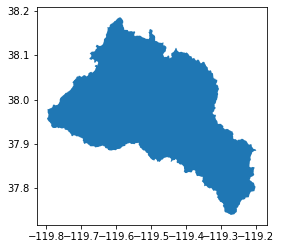

In [11]:
gdf_exploded.plot()

In [12]:
gdf_exploded.type

1  0    Polygon
dtype: object

In [13]:
# create ipyleaflet map in specified projection
m = sliderule.ipysliderule.leaflet(SRwidgets.projection.value)
m.add_layer(layers=SRwidgets.layers.value)

# Comment this section out if you want to draw your own polygon!
# ---
#box = shapely.geometry.Polygon([(-108.3,38.9), (-108.0,38.9), (-108.0,39.1), (-108.3, 39.1)])
#geobox = gpd.GeoDataFrame(geometry=[box], crs='EPSG:4326')
default_polygon = sliderule.io.from_geodataframe(gdf_exploded)
geodata = ipyleaflet.GeoData(geo_dataframe=gdf_exploded)
m.map.add_layer(geodata)
# ---

m.map

Map(center=[39, -108], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [14]:
#%%time
# sliderule asset and data release
asset = SRwidgets.asset.value
release = SRwidgets.release.value

# build sliderule parameters using latest values from widget
params = {
    # surface type: 0-land, 1-ocean, 2-sea ice, 3-land ice, 4-inland water
    "srt": SRwidgets.surface_type.index,
    # length of ATL06-SR segment in meters
    "len": SRwidgets.length.value,
    # step distance for successive ATL06-SR segments in meters
    "res": SRwidgets.step.value,
    # confidence level for PE selection
    "cnf": SRwidgets.confidence.value,
    # ATL08 land surface classifications
    "atl08_class": list(SRwidgets.land_class.value),
    # maximum iterations, not including initial least-squares-fit selection
    "maxi": SRwidgets.iteration.value,
    # minimum along track spread
    "ats": SRwidgets.spread.value,
    # minimum PE count
    "cnt": SRwidgets.count.value,
    # minimum height of PE window in meters
    "H_min_win": SRwidgets.window.value,
    # maximum robust dispersion in meters
    "sigma_r_max": SRwidgets.sigma.value
}

region = sliderule.icesat2.toregion(gdf_exploded)
params["poly"] = region["poly"]   # will always be the convex hull of the polygon
params["raster"] = region["raster"]   # raster will include all vertices, including holes. This is more processing, but is only an issue with very large requests.
gdf = sliderule.icesat2.atl06p(params, asset, version=release)

In [15]:
print(f'Returned {gdf.shape[0]} records')
gdf.head()

Returned 155567 records


,distance,h_sigma,rgt,delta_time,pflags,dh_fit_dy,segment_id,w_surface_window_final,dh_fit_dx,h_mean,spot,gt,cycle,rms_misfit,n_fit_photons,geometry
time,,,,,,,,,,,,,,,,
2018-10-15 23:22:20.018965444,4.215353e+06,0.033182,265,2.488094e+07,0,0.0,210188,3.0,-0.018228,2501.377184,4,30,1,0.091912,15,POINT (-119.62341 37.88878)
2018-10-15 23:22:20.021811344,4.215373e+06,0.028329,265,2.488094e+07,0,0.0,210189,3.0,-0.010939,2501.116873,4,30,1,0.109110,18,POINT (-119.62343 37.88896)
2018-10-15 23:22:20.027481712,4.215413e+06,0.032855,265,2.488094e+07,0,0.0,210191,3.0,-0.000515,2501.053838,4,30,1,0.107823,11,POINT (-119.62348 37.88932)
2018-10-15 23:22:20.030305900,4.215434e+06,0.041974,265,2.488094e+07,0,0.0,210192,3.0,0.008181,2501.176924,4,30,1,0.156936,14,POINT (-119.62350 37.88950)
2018-10-15 23:22:20.033126928,4.215454e+06,0.045422,265,2.488094e+07,0,0.0,210193,3.0,0.004802,2501.271832,4,30,1,0.169124,14,POINT (-119.62352 37.88968)


In [24]:
widgets.VBox([
    SRwidgets.variable,
    SRwidgets.cmap,
    SRwidgets.reverse,
])

In [25]:
m.GeoData(gdf, column_name=SRwidgets.variable.value, cmap='viridis',
    max_plot_points=10000, tooltip=True, colorbar=True)

ValueError: Can't clean for JSON: datetime.date(2018, 10, 15)

#### Create plots for a single track

In [ ]:
# selection for reference ground track
RGTs = [str(int(x)) for x in gdf.rgt.unique()]
SRwidgets.rgt = widgets.Dropdown(
    options=RGTs,
    value=RGTs[1], # You can change this with the pull-down widget below!
    description="RGT:",
    description_tooltip="RGT: Reference Ground Track to plot",
    disabled=False
)

# selection for ground track
ground_track_options = ["gt1l","gt1r","gt2l","gt2r","gt3l","gt3r"]
SRwidgets.ground_track = widgets.Dropdown(
    options=ground_track_options,
    value='gt1l',
    description="Track:",
    description_tooltip="Track: Ground Track to plot",
    disabled=False
)      
widgets.VBox([
    SRwidgets.rgt,
    SRwidgets.ground_track,
])

## Save as a pickle to avoid the weird datetime index issues

In [19]:
out_fn = '../../data/tuolumne_all_sr-atl06-09282022.pkl'

with open(out_fn, 'wb') as f:
    pickle.dump(gdf, f)